In [1]:
!pip install python-chess numpy numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148498 sha256=1574d5d61b9c7b448a1e204bf04936ece91e04079efe00801172c2ff5fd87e7e
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [2]:
import requests
requests.get('http://www.google.com',timeout=10).ok


True

In [3]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [4]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



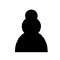
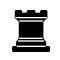
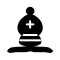
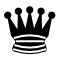
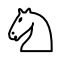
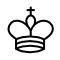
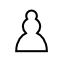
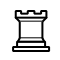
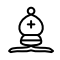
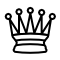
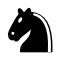
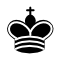

In [5]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

 Chess bot
    - RAM: 5MB max
    - CPU: Single 2.20GHz core
    - Tamaño: <64KB comprimido
    - Tiempo: 0.1s simple delay
    - RAM total controlada: ~4.8MB
    - Valores y tablas compactas (~800KB total)
    - PST minimalistas pero efectivas

https://www.chessprogramming.org/Simplified_Evaluation_Function

In [6]:
%%writefile main.py
import time
import random
from Chessnut import Game

# Optimized piece values based on more recent engine evaluations
piece = {
    "P": 100,    # Pawn
    "N": 320,    # Knight
    "B": 330,    # Bishop
    "R": 500,    # Rook
    "Q": 900,    # Queen
    "K": 20000   # King
}

# Improved piece-square tables with better positional understanding
pst = {
    'P': (   0,   0,   0,   0,   0,   0,   0,   0,
            80,  80,  80,  80,  80,  80,  80,  80,
            50,  50,  50,  50,  50,  50,  50,  50,
            10,  10,  20,  30,  30,  20,  10,  10,
             5,   5,  10,  25,  25,  10,   5,   5,
             0,   0,   0,  20,  20,   0,   0,   0,
             5,  -5, -10,   0,   0, -10,  -5,   5,
             0,   0,   0,   0,   0,   0,   0,   0),
    'N': ( -50, -40, -30, -30, -30, -30, -40, -50,
           -40, -20,   0,   0,   0,   0, -20, -40,
           -30,   0,  10,  15,  15,  10,   0, -30,
           -30,   5,  15,  20,  20,  15,   5, -30,
           -30,   0,  15,  20,  20,  15,   0, -30,
           -30,   5,  10,  15,  15,  10,   5, -30,
           -40, -20,   0,   5,   5,   0, -20, -40,
           -50, -40, -30, -30, -30, -30, -40, -50),
    'B': ( -20, -10, -10, -10, -10, -10, -10, -20,
           -10,   0,   0,   0,   0,   0,   0, -10,
           -10,   0,   5,  10,  10,   5,   0, -10,
           -10,   5,   5,  10,  10,   5,   5, -10,
           -10,   0,  10,  10,  10,  10,   0, -10,
           -10,  10,  10,  10,  10,  10,  10, -10,
           -10,   5,   0,   0,   0,   0,   5, -10,
           -20, -10, -10, -10, -10, -10, -10, -20),
    'R': (   0,   0,   0,   0,   0,   0,   0,   0,
             5,  10,  10,  10,  10,  10,  10,   5,
            -5,   0,   0,   0,   0,   0,   0,  -5,
            -5,   0,   0,   0,   0,   0,   0,  -5,
            -5,   0,   0,   0,   0,   0,   0,  -5,
            -5,   0,   0,   0,   0,   0,   0,  -5,
            -5,   0,   0,   0,   0,   0,   0,  -5,
             0,   0,   0,   5,   5,   0,   0,   0),
    'Q': ( -20, -10, -10,  -5,  -5, -10, -10, -20,
           -10,   0,   0,   0,   0,   0,   0, -10,
           -10,   0,   5,   5,   5,   5,   0, -10,
            -5,   0,   5,   5,   5,   5,   0,  -5,
             0,   0,   5,   5,   5,   5,   0,  -5,
           -10,   5,   5,   5,   5,   5,   0, -10,
           -10,   0,   5,   0,   0,   0,   0, -10,
           -20, -10, -10,  -5,  -5, -10, -10, -20),
    'K': ( -30, -40, -40, -50, -50, -40, -40, -30,
           -30, -40, -40, -50, -50, -40, -40, -30,
           -30, -40, -40, -50, -50, -40, -40, -30,
           -30, -40, -40, -50, -50, -40, -40, -30,
           -20, -30, -30, -40, -40, -30, -30, -20,
           -10, -20, -20, -20, -20, -20, -20, -10,
            20,  20,   0,   0,   0,   0,  20,  20,
            20,  30,  10,   0,   0,  10,  30,  20),
}

# Optimized search constants
MATE_LOWER = piece['K'] - 10 * piece['Q']
MATE_UPPER = piece['K'] + 10 * piece['Q']

# Size optimization for transposition table
TT_SIZE = 1024 * 64  # Increased to 64K entries

class TranspositionTable:
    def __init__(self, size=TT_SIZE):
        self.table = {}
        self.size = size
        self.hits = 0
        self.stores = 0
        self.current_age = 0

    def new_search(self):
        self.current_age += 1
    
    def _calculate_entry_score(self, entry):
        depth, score, move, node_type, age = entry
        depth_score = depth * 100
        age_factor = max(0, 1.0 - (self.current_age - age) / 100)
        type_bonus = {'exact': 300, 'lower': 200, 'upper': 100}.get(node_type, 0)
        return depth_score + (type_bonus * age_factor)
    
    def _replace_entries(self):
        min_depth = float('inf')
        oldest_age = -1
        key_to_replace = None

        for key, (depth, score, move, node_type, age) in self.table.items():
            if depth < min_depth or (depth == min_depth and age > oldest_age):
                min_depth = depth
                oldest_age = age
                key_to_replace = key

        if key_to_replace is not None:
            del self.table[key_to_replace]

    def store(self, key, depth, score, move, node_type='exact'):
        if len(self.table) >= self.size:
            self._replace_entries()
        self.table[key] = (depth, score, move, node_type, self.current_age)
        self.stores += 1
    
    def lookup(self, key):
        entry = self.table.get(key)
        if entry:
            self.hits += 1
            return entry[:-1]
        return None
    
    def get_statistics(self):
        hit_rate = (self.hits / max(1, self.stores + self.hits)) * 100
        return {
            'size': len(self.table),
            'capacity': self.size,
            'stores': self.stores,
            'hits': self.hits,
            'hit_rate': f"{hit_rate:.2f}%",
            'current_age': self.current_age
        }

class Sunfish:
    def __init__(self):
        self.tt = TranspositionTable()
        self.nodes = 0
        self.start_time = 0
        self.max_time = 0
        self.history = set()
        self.killer_moves = [[None] * 2 for _ in range(64)]
        self.history_table = {}
    
    def reset(self):
        self.tt = TranspositionTable()
        self.nodes = 0
        self.history.clear()
        self.killer_moves = [[None] * 2 for _ in range(64)]
        self.history_table.clear()
    
    def is_time_left(self):
        return time.time() - self.start_time < self.max_time
    def evaluate_position(self, game):
        """
        Evaluación avanzada que incluye material, posición, movilidad,
        seguridad del rey y estructura de peones.
        """
        if game.status == Game.CHECKMATE:
            return -MATE_UPPER

        score = 0
        board = game.board
        
        # Arrays para análisis de estructura de peones
        white_pawns = [0] * 8  # Cuenta de peones blancos por columna
        black_pawns = [0] * 8  # Cuenta de peones negros por columna
        
        # Material y posición básica
        white_material = black_material = 0
        white_position = black_position = 0
        
        # Análisis del tablero
        for square in range(64):
            p = board.get_piece(square)
            if p != ' ':
                is_white = p.isupper()
                p = p.upper()
                file = square % 8
                rank = square // 8
                
                # Material y posición
                value = piece[p]
                if is_white:
                    white_material += value
                    white_position += pst[p][square]
                else:
                    black_material += value
                    black_position += pst[p][63 - square]
                
                # Conteo de peones para estructura
                if p == 'P':
                    if is_white:
                        white_pawns[file] += 1
                    else:
                        black_pawns[file] += 1

        # 1. Evaluación material y posicional básica
        score = (white_material - black_material) + \
                (white_position - black_position) // 2

        # 2. Movilidad
        white_mobility = len(list(self._get_side_moves(game, True)))
        black_mobility = len(list(self._get_side_moves(game, False)))
        mobility_score = (white_mobility - black_mobility) * 10

        # 3. Seguridad del Rey
        white_king_safety = self._evaluate_king_safety(game, True)
        black_king_safety = self._evaluate_king_safety(game, False)
        king_safety_score = white_king_safety - black_king_safety

        # 4. Estructura de peones
        white_pawn_structure = self._evaluate_pawn_structure(game, white_pawns, True)
        black_pawn_structure = self._evaluate_pawn_structure(game, black_pawns, False)
        pawn_structure_score = white_pawn_structure - black_pawn_structure

        # Añadir evaluación de desarrollo si estamos en apertura
        if not self.is_endgame(game):
            development_score = self.evaluate_development(game)
            score += development_score
            
            # Penalización extra por rey expuesto en apertura
            if game.status == Game.CHECK:
                score -= 150  # Penalización fuerte por jaque en apertura

        # Combinar todos los componentes
        final_score = score + \
                     mobility_score + \
                     king_safety_score + \
                     pawn_structure_score

        return final_score if board.is_whites_turn() else -final_score

    def _get_side_moves(self, game, is_white):
        """Obtiene los movimientos disponibles para un lado"""
        game_copy = Game(game.get_fen())
        game_copy.board.turn = is_white
        return game_copy.get_moves()

    def _evaluate_king_safety(self, game, is_white):
        """
        Evalúa la seguridad del rey considerando:
        - Protección de peones
        - Exposición
        - Presión enemiga
        """
        score = 0
        board = game.board
        
        # Encontrar posición del rey
        king = 'K' if is_white else 'k'
        king_square = None
        for square in range(64):
            if board.get_piece(square) == king:
                king_square = square
                break
        
        if king_square is None:
            return 0
            
        king_file = king_square % 8
        king_rank = king_square // 8
        
        # 1. Protección de peones
        pawn_shield_score = 0
        pawn = 'P' if is_white else 'p'
        shield_squares = self._get_pawn_shield_squares(king_square, is_white)
        
        for sq in shield_squares:
            if 0 <= sq < 64 and board.get_piece(sq) == pawn:
                pawn_shield_score += 20
        
        # 2. Exposición del rey
        exposure_score = 0
        if king_file in [0, 7]:  # Rey en los bordes
            exposure_score += 10
        
        # Penalizar rey en centro en apertura/mediojuego
        if not self.is_endgame(game):
            center_distance = min(3 - abs(3.5 - king_file), 3)
            exposure_score -= center_distance * 15
        
        # 3. Presión enemiga
        pressure_score = 0
        enemy_moves = list(self._get_side_moves(game, not is_white))
        for move in enemy_moves:
            to_square = Game.xy2i(move[2:4])
            # Penalizar ataques cerca del rey
            distance = max(abs(to_square % 8 - king_file),
                          abs(to_square // 8 - king_rank))
            if distance <= 2:
                pressure_score -= 5 * (3 - distance)
        
        return pawn_shield_score + exposure_score + pressure_score
    def _get_pawn_shield_squares(self, king_square, is_white):
        """Retorna las casillas donde deberían estar los peones protectores"""
        file = king_square % 8
        rank = king_square // 8
        squares = []
        
        # Definir offsets para el escudo de peones
        if is_white:
            rank_offset = -1  # Peones una fila arriba del rey
        else:
            rank_offset = 1  # Peones una fila abajo del rey
        
        # Añadir casillas frontales y diagonales
        for f in range(max(0, file - 1), min(8, file + 2)):
            square = (rank + rank_offset) * 8 + f
            if 0 <= square < 64:
                squares.append(square)
        
        return squares

    def _evaluate_pawn_structure(self, game, pawn_counts, is_white):
        """
        Evalúa la estructura de peones considerando:
        - Peones doblados
        - Peones aislados
        - Peones pasados
        - Peones retrasados
        """
        score = 0
        board = game.board
        
        for file in range(8):
            # 1. Peones doblados
            if pawn_counts[file] > 1:
                score -= 20 * (pawn_counts[file] - 1)
            
            # 2. Peones aislados
            if pawn_counts[file] > 0:
                has_neighbors = False
                if file > 0 and pawn_counts[file - 1] > 0:
                    has_neighbors = True
                if file < 7 and pawn_counts[file + 1] > 0:
                    has_neighbors = True
                if not has_neighbors:
                    score -= 15
            
            # 3. Evaluar peones pasados y retrasados
            for rank in range(8):
                square = rank * 8 + file
                p = board.get_piece(square)
                
                if p.upper() == 'P' and p.isupper() == is_white:
                    # Peón pasado
                    if self._is_passed_pawn(game, square, is_white):
                        bonus = 20 + (is_white and 7-rank or rank) * 10
                        score += bonus
                    
                    # Peón retrasado
                    elif self._is_backward_pawn(game, square, is_white):
                        score -= 15
        
        return score

    def _is_passed_pawn(self, game, square, is_white):
        """Determina si un peón es pasado"""
        board = game.board
        file = square % 8
        rank = square // 8
        
        # Rango de filas a revisar
        if is_white:
            rank_range = range(rank - 1, -1, -1)  # Hacia arriba
        else:
            rank_range = range(rank + 1, 8)  # Hacia abajo
        
        # Comprobar peones enemigos que puedan bloquear
        enemy_pawn = 'p' if is_white else 'P'
        for r in rank_range:
            # Revisar columna actual y adyacentes
            for f in range(max(0, file - 1), min(8, file + 2)):
                if board.get_piece(r * 8 + f) == enemy_pawn:
                    return False
        return True

    def _is_backward_pawn(self, game, square, is_white):
        """Determina si un peón está retrasado"""
        board = game.board
        file = square % 8
        rank = square // 8
        
        # Verificar si hay peones amigos en columnas adyacentes más adelantados
        friend_pawn = 'P' if is_white else 'p'
        ahead_range = range(rank - 1, -1, -1) if is_white else range(rank + 1, 8)
        
        has_support = False
        for f in [file - 1, file + 1]:
            if 0 <= f < 8:
                for r in ahead_range:
                    if board.get_piece(r * 8 + f) == friend_pawn:
                        has_support = True
                        break
        
        return not has_support

    def evaluate_development(self, game):
        """Evalúa el desarrollo de piezas y control del centro"""
        score = 0
        board = game.board
        
        # Penalizaciones por movimientos tempranos de dama
        queen_moves = self._count_queen_moves(game)
        if queen_moves > 0 and not self.is_endgame(game):
            score -= queen_moves * 30
        
        # Desarrollo de piezas menores
        developed_pieces = self._count_developed_pieces(game)
        if not self.is_endgame(game):
            score += developed_pieces * 20
        
        # Control del centro
        center_control = self._evaluate_center_control(game)
        score += center_control
        
        return score
    def _count_queen_moves(self, game):
        """Cuenta movimientos de dama en apertura"""
        moves = game.get_fen().split(' ')[-1].split()
        queen_moves = 0
        
        for move in moves[:20]:  # Solo primeros 20 movimientos
            if move[0] == 'Q' or (len(move) > 1 and move[0] in 'abcdefgh' and 
                game.board.get_piece(Game.xy2i(move[2:4])) in 'Qq'):
                queen_moves += 1
        
        return queen_moves

    def _count_developed_pieces(self, game):
        """Cuenta piezas menores desarrolladas"""
        board = game.board
        score = 0
        
        # Posiciones iniciales de piezas menores
        initial_squares = {
            'N': [1, 6],  # Caballos
            'B': [2, 5]   # Alfiles
        }
        
        for piece in ['N', 'B']:
            for square in range(64):
                p = board.get_piece(square)
                if p.upper() == piece:
                    is_white = p.isupper()
                    init_rank = 7 if is_white else 0
                    file = square % 8
                    
                    # Si la pieza no está en su casilla inicial
                    if square // 8 != init_rank or file not in initial_squares[piece]:
                        score += 1
        
        return score

    def _evaluate_center_control(self, game):
        """Evalúa el control del centro"""
        board = game.board
        score = 0
        center_squares = [27, 28, 35, 36]  # e4, d4, e5, d5
        
        for square in center_squares:
            # Peones en el centro
            p = board.get_piece(square)
            if p.upper() == 'P':
                score += 15 if p.isupper() else -15
            
            # Control del centro por piezas
            white_control = self._square_attacked_by(game, square, True)
            black_control = self._square_attacked_by(game, square, False)
            score += (white_control - black_control) * 5
        
        return score

    def _square_attacked_by(self, game, square, is_white):
        """Cuenta cuántas piezas atacan una casilla"""
        count = 0
        moves = self._get_side_moves(game, is_white)
        target = Game.i2xy(square)
        
        for move in moves:
            if move[2:4] == target:
                count += 1
        
        return count

    def is_endgame(self, game):
        """Determina si la posición es un final"""
        board = game.board
        queens = 0
        minor_pieces = 0
        
        for square in range(64):
            piece = board.get_piece(square)
            if piece.upper() == 'Q':
                queens += 1
            elif piece.upper() in ['N', 'B']:
                minor_pieces += 1
        
        return queens == 0 or (queens == 2 and minor_pieces <= 2)

    def try_null_move(self, game, depth, beta, alpha, ply):
        """Implementa Null Move Pruning mejorado"""
        if depth < 3 or self.is_endgame(game) or game.status == Game.CHECK:
            return False

        # Adaptación dinámica de R
        R = 3 if depth > 6 else 2
        
        # Realizar el movimiento nulo
        null_game = Game(game.get_fen())
        null_game.board.turn = not null_game.board.turn
        
        # Búsqueda con profundidad reducida
        _, score = self.alphabeta(null_game, depth - 1 - R, -beta, -beta + 1, ply + 1)
        score = -score
        
        if score >= beta:
            if score >= MATE_LOWER:
                score = beta
            if not self.is_dangerous_position(game):
                return True
        
        return False
    def is_dangerous_position(self, game):
        """Determina si una posición es peligrosa para null move"""
        board = game.board
        white_material = black_material = 0
        
        for square in range(64):
            p = board.get_piece(square)
            if p != ' ':
                value = piece[p.upper()]
                if p.isupper():
                    white_material += value
                else:
                    black_material += value
        
        return abs(white_material - black_material) > piece['Q']

    def order_moves(self, game, depth, killer1=None, killer2=None):
        """Ordenamiento de movimientos avanzado"""
        moves = list(game.get_moves())
        move_scores = []
        
        for move in moves:
            score = 0
            # Agregar puntuación de la historia
            score += self.history_table.get(move, 0)
            
            # MVV-LVA
            piece_to = game.board.get_piece(Game.xy2i(move[2:4]))
            if piece_to != ' ':
                score += 10 * piece[piece_to.upper()]
            
            move_scores.append((move, score))
        
        return [move for move, _ in sorted(move_scores, key=lambda x: x[1], reverse=True)]

    def quiescence(self, game, alpha, beta, depth=0):
        """Búsqueda de quietud mejorada"""
        self.nodes += 1
        
        if not self.is_time_left():
            return alpha
        
        stand_pat = self.evaluate_position(game)
        
        if stand_pat >= beta:
            return beta
        if stand_pat > alpha:
            alpha = stand_pat
        
        if depth < -4:
            return alpha
        
        # Solo considerar capturas y jaques
        for move in self.order_moves(game, depth):
            if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
                g = Game(game.get_fen())
                g.apply_move(move)
                score = -self.quiescence(g, -beta, -alpha, depth - 1)
                
                if score >= beta:
                    return beta
                if score > alpha:
                    alpha = score
        
        return alpha

    def should_extend_search(self, game, move, depth, ply):
        """Determina extensiones de búsqueda"""
        extension = 0
        g = Game(game.get_fen())
        g.apply_move(move)
        
        # Extensión por jaque
        if g.status == Game.CHECK:
            extension += 1
        
        # Extensión por captura de pieza importante
        piece_captured = game.board.get_piece(Game.xy2i(move[2:4]))
        if piece_captured.upper() in ['Q', 'R']:
            extension += 1
        elif piece_captured.upper() in ['B', 'N']:
            extension += 0.5
        
        # Extensión por peón en séptima
        piece_moved = game.board.get_piece(Game.xy2i(move[0:2]))
        to_rank = 8 - int(move[3])
        if piece_moved.upper() == 'P':
            if (piece_moved.isupper() and to_rank == 1) or \
               (piece_moved.islower() and to_rank == 6):
                extension += 1
        
        # Extensión por recaptura
        if self.is_recapture(game, move, ply):
            extension += 0.5
        
        # Extensión por posición crítica
        if self.is_critical_position(game, depth):
            extension += 0.5
        
        return min(extension, 2)

    def is_recapture(self, game, move, ply):
        """Verifica si es un movimiento de recaptura"""
        if ply == 0:
            return False
            
        moves = game.get_fen().split(' ')[-1].split()
        if not moves:
            return False
            
        last_move = moves[-1]
        return move[2:4] == last_move[2:4]

    def is_critical_position(self, game, depth):
        """Determina si la posición es crítica"""
        eval_current = self.evaluate_position(game)
        
        if abs(eval_current) > MATE_LOWER:
            return True
        
        material_diff = abs(self._count_material(game, True) - 
                          self._count_material(game, False))
        if material_diff > piece['R']:
            return True
        
        if self._count_attacked_pieces(game) >= 2:
            return True
        
        return False

    def _count_material(self, game, is_white):
        """Cuenta el material total para un lado"""
        total = 0
        board = game.board
        
        for square in range(64):
            p = board.get_piece(square)
            if p != ' ' and p.isupper() == is_white:
                total += piece[p.upper()]
        
        return total

    def _count_attacked_pieces(self, game):
        """Cuenta piezas atacadas en la posición"""
        attacked = 0
        board = game.board
        
        for square in range(64):
            p = board.get_piece(square)
            if p != ' ':
                g = Game(game.get_fen())
                g.board.turn = not g.board.turn
                for move in g.get_moves():
                    if move[2:4] == Game.i2xy(square):
                        attacked += 1
                        break
        
        return attacked
    def alphabeta(self, game, depth, alpha, beta, ply=0):
        """Enhanced alpha-beta search with selective extensions"""
        self.nodes += 1
        
        if not self.is_time_left():
            return None, alpha
        
        # Check for repetition
        if game.get_fen() in self.history:
            return None, 0
        
        # Transposition table lookup
        tt_entry = self.tt.lookup(game.get_fen())
        if tt_entry and tt_entry[0] >= depth:
            score = tt_entry[1]
            if tt_entry[3] == 'exact':
                return tt_entry[2], score
            elif tt_entry[3] == 'lower' and score <= alpha:
                return tt_entry[2], alpha
            elif tt_entry[3] == 'upper' and score >= beta:
                return tt_entry[2], beta
        
        if depth <= 0:
            return None, self.quiescence(game, alpha, beta)
        
        # Null Move Pruning
        if depth >= 3 and self.try_null_move(game, depth, beta, alpha, ply):
            return None, beta
        
        moves = self.order_moves(game, depth,
                               self.killer_moves[ply][0],
                               self.killer_moves[ply][1])
        
        if not moves:
            if game.status == Game.CHECKMATE:
                return None, -MATE_UPPER
            return None, 0
        
        best_move = moves[0]
        original_alpha = alpha
        
        for move in moves:
            # Calcular extensión para este movimiento
            extension = self.should_extend_search(game, move, depth, ply)
            
            g = Game(game.get_fen())
            g.apply_move(move)
            
            # Late Move Reduction con consideración de extensiones
            if depth >= 3 and not extension and \
               game.board.get_piece(Game.xy2i(move[2:4])) == ' ':
                _, score = self.alphabeta(g, depth-2, -beta, -alpha, ply + 1)
                score = -score
                if score <= alpha:
                    continue
            
            # Ajustar profundidad basado en la extensión
            next_depth = depth - 1 + extension
            
            _, score = self.alphabeta(g, next_depth, -beta, -alpha, ply + 1)
            score = -score
            
            if score > alpha:
                alpha = score
                best_move = move
                
                # Update killer moves
                if game.board.get_piece(Game.xy2i(move[2:4])) == ' ':
                    if move != self.killer_moves[ply][0]:
                        self.killer_moves[ply][1] = self.killer_moves[ply][0]
                        self.killer_moves[ply][0] = move
                
                # Update history table
                self.history_table[move] = self.history_table.get(move, 0) + depth * depth
                
                if score >= beta:
                    self.tt.store(game.get_fen(), depth, beta, move, 'lower')
                    return move, beta
        
        # Store position in transposition table
        node_type = 'exact' if alpha > original_alpha else 'upper'
        self.tt.store(game.get_fen(), depth, alpha, best_move, node_type)
        
        return best_move, alpha
    
    def select_move(self, game, max_time):
        """Enhanced iterative deepening search"""
        self.start_time = time.time()
        self.max_time = max_time * 0.95
        
        self.history.add(game.get_fen())
        best_move = None
        best_score = float('-inf')
        
        # Iterative deepening
        for depth in range(1, 20):
            if not self.is_time_left():
                break
            
            move, score = self.alphabeta(game, depth, float('-inf'), float('inf'))
            
            if move and self.is_time_left():
                best_move = move
                best_score = score
            
            # Early exit on forced mate
            if abs(score) > MATE_LOWER:
                break
            
            # Time management
            elapsed = time.time() - self.start_time
            if elapsed > self.max_time * 0.3 and depth >= 5:
                break
        
        return best_move

def make_move(move, time_start):
    duration = round(time.time() - time_start, 3)
    print(f'[{move}, {duration}]')
    return move

def chess_bot(obs):
    time_start = time.time()
    max_time = 0.095  # 95ms safety margin
    game = Game(obs.board)
    moves = list(game.get_moves())
    
    # Check for immediate mates
    for move in moves:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return make_move(move, time_start)
    
    # Opening book
    simple_openings = {
        'white': {
            0: ['e2e4', 'd2d4', 'c2c4', 'g1f3'],  # Primer movimiento
            2: {
                'e2e4': ['g1f3', 'b1c3', 'f1c4', 'd2d4'],  # Respuestas a e4
                'd2d4': ['c2c4', 'g1f3', 'b1c3', 'e2e3'],  # Respuestas a d4
                'c2c4': ['g1f3', 'b1c3', 'e2e4'],          # Respuestas a c4
                'g1f3': ['d2d4', 'c2c4', 'g2g3'],          # Respuestas a Nf3
            },
        },
        'black': {
            1: {
                'e2e4': ['e7e5', 'c7c5', 'e7e6', 'c7c6'],   # Respuestas a e4
                'd2d4': ['d7d5', 'g8f6', 'f7f5'],           # Respuestas a d4
                'c2c4': ['e7e5', 'c7c5', 'g8f6'],           # Respuestas a c4
                'g1f3': ['d7d5', 'g8f6', 'c7c5'],           # Respuestas a Nf3
            },
            3: {
                'g1f3': ['g8f6', 'e7e6', 'd7d5'],  # Desarrollo sólido
                'b1c3': ['g8f6', 'd7d5', 'c7c5'],  # Evitar debilidades tempranas
            },
        },
    }
    
    # Opening book usage
    if obs.step < 4:
        color = 'white' if obs.mark == 'white' else 'black'
        if obs.step in simple_openings[color]:
            opening_moves = simple_openings[color][obs.step]
            if isinstance(opening_moves, list):
                valid_moves = [m for m in opening_moves if m in moves]
                if valid_moves:
                    return make_move(random.choice(valid_moves), time_start)
            else:
                last_move = obs.board.split()[-1] if ' ' in obs.board else None
                if last_move and last_move in opening_moves:
                    valid_responses = [m for m in opening_moves[last_move] if m in moves]
                    if valid_responses:
                        return make_move(random.choice(valid_responses), time_start)
    
    # Dynamic time management
    remaining_moves = max(40 - obs.step, 20)
    base_time = max_time * 0.8
    time_per_move = base_time / remaining_moves
    
    # Adjust time based on position complexity
    position_complexity = len(moves) / 20
    adjusted_time = min(max_time, time_per_move * position_complexity)
    
    # Use the optimized engine
    engine = Sunfish()
    best_move = engine.select_move(game, adjusted_time)
    
    if best_move:
        return make_move(best_move, time_start)
    
    # Fallback moves
    captures = [move for move in moves if game.board.get_piece(Game.xy2i(move[2:4])) != ' ']
    if captures:
        return make_move(random.choice(captures), time_start)
    return make_move(random.choice(moves), time_start)

Writing main.py


[d2d4, 0.11]
[h7h5, 0.148]
[g2g4, 0.173]
[h5g4, 0.184]
[e1d2, 0.233]
[h8h2, 0.169]
[h1h2, 0.172]
[g8f6, 0.15]
[h2h7, 0.191]
[f6h7, 0.162]
[e2e4, 0.124]
[b7b5, 0.147]
[f1b5, 0.183]
[b8c6, 0.137]
[b5c6, 0.204]
[d7c6, 0.114]
[d1g4, 0.158]
[d8d4, 0.194]
[d2e1, 0.03]
[d4e4, 0.459]
[g4e4, 0.079]
[c8h3, 0.211]
[e4c6, 0.364]
[h3d7, 0.025]
[c6c7, 0.36]
[f7f5, 0.196]
[c7d7, 0.268]
[e8d7, 0.017]
[b2b3, 0.112]
[a7a5, 0.118]
[e1f1, 0.128]
[h7f6, 0.121]
[f1e1, 0.141]
[d7e8, 0.164]
[e1d1, 0.127]
[e7e5, 0.123]
[c2c3, 0.14]
[e8e7, 0.149]
[f2f4, 0.128]
[e5f4, 0.126]
[c1f4, 0.098]
[f6d5, 0.138]
[f4g3, 0.15]
[d5c3, 0.136]
[b1c3, 0.032]
[e7f6, 0.1]
[g3f2, 0.15]
[g7g5, 0.133]
[f2b6, 0.152]
[f5f4, 0.138]
[b6a5, 0.157]
[a8a5, 0.13]
[g1f3, 0.11]
[a5a2, 0.156]
[c3a2, 0.137]
[f8a3, 0.063]
[f3g5, 0.069]
[f6g5, 0.057]
[a1b1, 0.034]
[g5f6, 0.049]
[b1a1, 0.037]
[f6g6, 0.051]
[d1d2, 0.036]
[a3e7, 0.072]
[d2c1, 0.081]
[e7d6, 0.056]
[c1c2, 0.032]
[d6e7, 0.075]
[a2c1, 0.076]
[e7h4, 0.083]
[c1e2, 0.072]
[g6f6, 0.093]
[e2


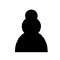
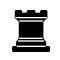
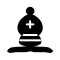
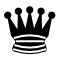
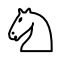
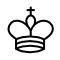
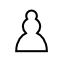
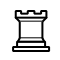
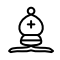
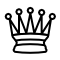
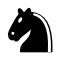
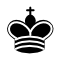

In [7]:
result = env.run(["main.py", "main.py"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=500, height=500) 